In [14]:
# @title Setup and Imports { display-mode: "form" }
# @markdown (double click to see the code)

import math
import os
import random

# import git
import imageio
import magnum as mn
import numpy as np

%matplotlib inline
from matplotlib import pyplot as plt

# function to display the topdown map
from PIL import Image

import habitat_sim
from habitat_sim.utils import common as utils
from habitat_sim.utils import viz_utils as vut

# repo = git.Repo(".", search_parent_directories=True)
# dir_path = repo.working_tree_dir
dir_path = "/Users/LeoHuang/Downloads/habitat-sim"
# data_path = os.path.join(dir_path, "data")
data_path = "/Users/LeoHuang/Downloads/habitat-sim/data"
print(f"data_path = {data_path}")
# @markdown Optionally configure the save path for video output:
output_directory = os.path.join(
    dir_path, "examples/tutorials/nav_output/"
)  # @param {type:"string"}
output_path = os.path.join(dir_path, output_directory)
if not os.path.exists(output_path):
    os.mkdir(output_path)

data_path = /Users/LeoHuang/Downloads/habitat-sim/data


In [15]:
# @title Define Observation Display Utility Function { display-mode: "form" }

# @markdown A convenient function that displays sensor observations with matplotlib.

# @markdown (double click to see the code)


# Change to do something like this maybe: https://stackoverflow.com/a/41432704
def display_sample(rgb_obs, semantic_obs=np.array([]), depth_obs=np.array([])):
    from habitat_sim.utils.common import d3_40_colors_rgb

    rgb_img = Image.fromarray(rgb_obs, mode="RGBA")

    arr = [rgb_img]
    titles = ["rgb"]
    if semantic_obs.size != 0:
        semantic_img = Image.new("P", (semantic_obs.shape[1], semantic_obs.shape[0]))
        semantic_img.putpalette(d3_40_colors_rgb.flatten())
        semantic_img.putdata((semantic_obs.flatten() % 40).astype(np.uint8))
        semantic_img = semantic_img.convert("RGBA")
        arr.append(semantic_img)
        titles.append("semantic")

    if depth_obs.size != 0:
        depth_img = Image.fromarray((depth_obs / 10 * 255).astype(np.uint8), mode="L")
        arr.append(depth_img)
        titles.append("depth")

    plt.figure(figsize=(12, 8))
    for i, data in enumerate(arr):
        ax = plt.subplot(1, 3, i + 1)
        ax.axis("off")
        ax.set_title(titles[i])
        plt.imshow(data)
    plt.show(block=False)


if __name__ == "__main__":
    import argparse

    parser = argparse.ArgumentParser()
    parser.add_argument("--no-display", dest="display", action="store_false")
    parser.add_argument("--no-make-video", dest="make_video", action="store_false")
    parser.set_defaults(show_video=True, make_video=True)
    args, _ = parser.parse_known_args()
    show_video = args.display
    display = args.display
    do_make_video = args.make_video
else:
    show_video = False
    do_make_video = False
    display = False

# import the maps module alone for topdown mapping
if display:
    from habitat.utils.visualizations import maps

In [16]:
# @title Configure Sim Settings

test_scene = os.path.join(
    data_path, "scene_datasets/mp3d_example/17DRP5sb8fy/17DRP5sb8fy.glb"
)
mp3d_scene_dataset = os.path.join(
    data_path, "scene_datasets/mp3d_example/mp3d.scene_dataset_config.json"
)

rgb_sensor = True  # @param {type:"boolean"}
depth_sensor = False  # @param {type:"boolean"}
semantic_sensor = False  # @param {type:"boolean"}

sim_settings = {
    # "width": 256,  # Spatial resolution of the observations
    "width": 4096,
    # "height": 256,
    "height": 4096,
    "scene": test_scene,  # Scene path
    "scene_dataset": mp3d_scene_dataset,  # the scene dataset configuration files
    "default_agent": 0,
    "sensor_height": 1.0,  # Height of sensors in meters
    "color_sensor": rgb_sensor,  # RGB sensor
    "depth_sensor": depth_sensor,  # Depth sensor
    "semantic_sensor": semantic_sensor,  # Semantic sensor
    "seed": 1,  # used in the random navigation
    "enable_physics": False,  # kinematics only
}

In [17]:
def make_cfg(settings):
    sim_cfg = habitat_sim.SimulatorConfiguration()
    sim_cfg.gpu_device_id = 0
    sim_cfg.scene_id = settings["scene"]
    sim_cfg.scene_dataset_config_file = settings["scene_dataset"]
    sim_cfg.enable_physics = settings["enable_physics"]

    # Note: all sensors must have the same resolution
    sensor_specs = []

    color_sensor_spec = habitat_sim.CameraSensorSpec()
    color_sensor_spec.uuid = "color_sensor"
    color_sensor_spec.sensor_type = habitat_sim.SensorType.COLOR
    color_sensor_spec.resolution = [settings["height"], settings["width"]]
    color_sensor_spec.position = [0.0, settings["sensor_height"], 0.0]
    color_sensor_spec.sensor_subtype = habitat_sim.SensorSubType.PINHOLE
    sensor_specs.append(color_sensor_spec)

    depth_sensor_spec = habitat_sim.CameraSensorSpec()
    depth_sensor_spec.uuid = "depth_sensor"
    depth_sensor_spec.sensor_type = habitat_sim.SensorType.DEPTH
    depth_sensor_spec.resolution = [settings["height"], settings["width"]]
    depth_sensor_spec.position = [0.0, settings["sensor_height"], 0.0]
    depth_sensor_spec.sensor_subtype = habitat_sim.SensorSubType.PINHOLE
    sensor_specs.append(depth_sensor_spec)

    semantic_sensor_spec = habitat_sim.CameraSensorSpec()
    semantic_sensor_spec.uuid = "semantic_sensor"
    semantic_sensor_spec.sensor_type = habitat_sim.SensorType.SEMANTIC
    semantic_sensor_spec.resolution = [settings["height"], settings["width"]]
    semantic_sensor_spec.position = [0.0, settings["sensor_height"], 0.0]
    semantic_sensor_spec.sensor_subtype = habitat_sim.SensorSubType.PINHOLE
    sensor_specs.append(semantic_sensor_spec)

    # Here you can specify the amount of displacement in a forward action and the turn angle
    agent_cfg = habitat_sim.agent.AgentConfiguration()
    agent_cfg.sensor_specifications = sensor_specs
    agent_cfg.action_space = {
        "move_forward": habitat_sim.agent.ActionSpec(
            "move_forward", habitat_sim.agent.ActuationSpec(amount=0.25)
        ),
        "turn_left": habitat_sim.agent.ActionSpec(
            "turn_left", habitat_sim.agent.ActuationSpec(amount=90.0)
        ),
        "turn_right": habitat_sim.agent.ActionSpec(
            "turn_right", habitat_sim.agent.ActuationSpec(amount=90.0)
        ),
        "look_up": habitat_sim.agent.ActionSpec(
            "look_up", habitat_sim.agent.ActuationSpec(amount=90.0)
        ),
        "look_down": habitat_sim.agent.ActionSpec(
            "look_down", habitat_sim.agent.ActuationSpec(amount=90.0)
        ),
    }

    return habitat_sim.Configuration(sim_cfg, [agent_cfg])

In [18]:
cfg = make_cfg(sim_settings)
# Needed to handle out of order cell run in Jupyter
try:  # Got to make initialization idiot proof
    sim.close()
except NameError:
    pass
sim = habitat_sim.Simulator(cfg)

PluginManager::Manager: duplicate static plugin StbImageImporter, ignoring
PluginManager::Manager: duplicate static plugin GltfImporter, ignoring
PluginManager::Manager: duplicate static plugin BasisImporter, ignoring
PluginManager::Manager: duplicate static plugin AssimpImporter, ignoring
PluginManager::Manager: duplicate static plugin AnySceneImporter, ignoring
PluginManager::Manager: duplicate static plugin AnyImageImporter, ignoring
[22:51:55:884592]:[Warning]:[Metadata] SceneDatasetAttributes.cpp(107)::addNewSceneInstanceToDataset : Dataset : 'mp3d' : Lighting Layout Attributes 'no_lights' specified in Scene Attributes but does not exist in dataset, so creating default.


Renderer: Intel(R) HD Graphics 6000 by Intel Inc.
OpenGL version: 4.1 INTEL-18.8.6
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_texture_storage
    GL_EXT_texture_filter_anisotropic
    GL_EXT_debug_label
    GL_EXT_debug_marker
Using driver workarounds:
    no-layout-qualifiers-on-old-glsl
    apple-buffer-texture-unbind-on-buffer-modify


In [19]:
# Produce a list of all traversable points at height zero (relative to room)
# Camera can have elevation, but traversability is checked at the floor
bounds = sim.pathfinder.get_bounds()
bound1 = bounds[0]
bound2 = bounds[1]
meters_per_pixel = 0.1 # Set this
floor = bound1[1]
print(f"Bounds: {bounds}")

xspan = np.abs(bound1[0] - bound2[0])
zspan = np.abs(bound1[2] - bound2[2])
x_resolution = int(xspan / meters_per_pixel)
z_resolution = int(zspan / meters_per_pixel)
startx = min(bound1[0], bound2[0])
startz = min(bound1[2], bound2[2])
# topdown_map = np.zeros((z_resolution, x_resolution), dtype=bool)
points = []

curz = startz
for h in range(z_resolution):
    curx = startx
    for w in range(x_resolution):
        point = np.array([curx, floor, curz])
        if sim.pathfinder.is_navigable(point): # Can add eps parameter for fuzziness
            points.append(point)
        curx += meters_per_pixel
    curz += meters_per_pixel

print(f"Number of traversable points: {len(points)}")
print("Traversable area:" + str(sim.pathfinder.navigable_area))
print(f"Top left corner: {points[0]}")
print(f"Bottom right corner: {points[-1]}")
print(points)

Bounds: (array([-11.59344 ,  -0.127553,  -5.392021], dtype=float32), array([4.757026, 4.278783, 2.88662 ], dtype=float32))
Number of traversable points: 5434
Traversable area:52.03893280029297
Top left corner: [-5.29344006 -0.127553   -5.09202118]
Bottom right corner: [-8.39344006 -0.127553    2.70797882]
[array([-5.29344006, -0.127553  , -5.09202118]), array([-5.19344006, -0.127553  , -5.09202118]), array([-0.09344006, -0.127553  , -5.09202118]), array([-5.99344006, -0.127553  , -4.99202118]), array([-5.89344006, -0.127553  , -4.99202118]), array([-5.79344006, -0.127553  , -4.99202118]), array([-5.69344006, -0.127553  , -4.99202118]), array([-5.59344006, -0.127553  , -4.99202118]), array([-5.49344006, -0.127553  , -4.99202118]), array([-5.39344006, -0.127553  , -4.99202118]), array([-5.29344006, -0.127553  , -4.99202118]), array([-5.19344006, -0.127553  , -4.99202118]), array([-5.09344006, -0.127553  , -4.99202118]), array([-1.59344006, -0.127553  , -4.99202118]), array([-1.49344006, 

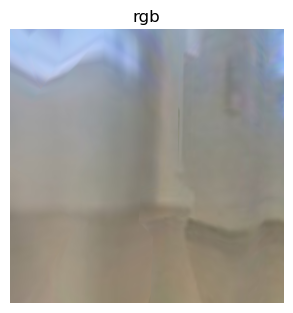

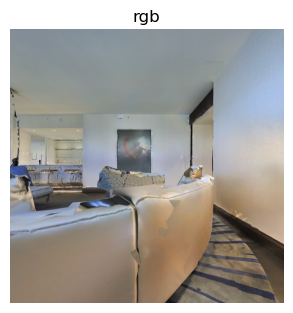

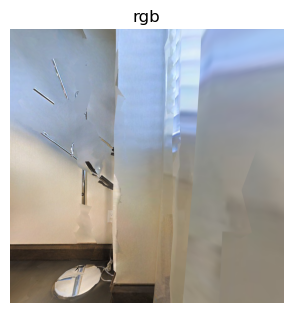

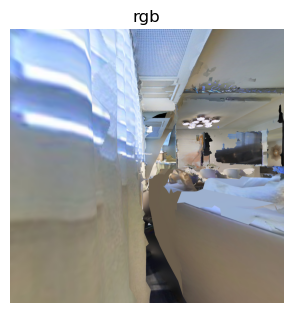

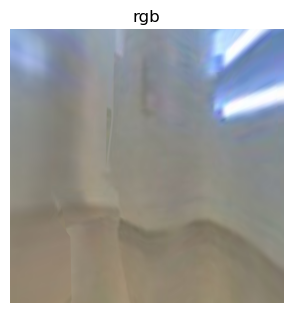

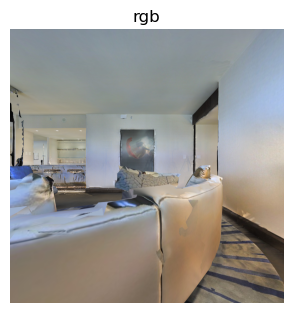

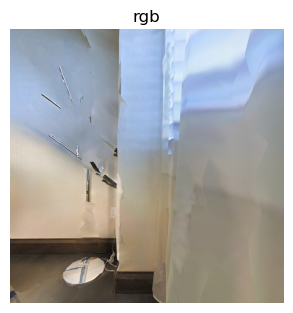

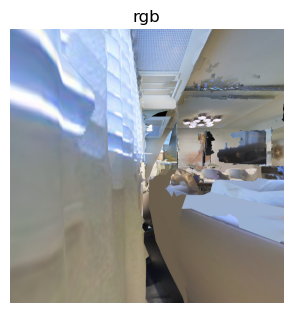

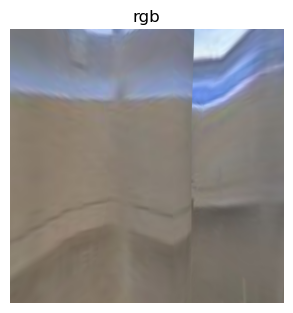

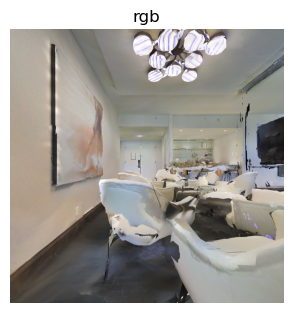

KeyboardInterrupt: 

In [20]:
agent = sim.initialize_agent(sim_settings["default_agent"])
agent_state = habitat_sim.AgentState()
rotations=[
[0,0,0,1], #front
[0,1,0,0], #back
[0, 0.7071, 0,0.7071], #left
[0, -0.7071, 0,0.7071], #right
#up -not sure yet
#down -not sure yet
]

for i, point in enumerate(points): 
    for j, rotation in enumerate(rotations):
        agent_state = habitat_sim.AgentState()
        agent_state.position = point  # in world space
        agent_state.rotation = rotation
        agent.set_state(agent_state)
        observation = sim.get_sensor_observations()
        display_sample(observation["color_sensor"])
        filename = os.path.join(output_path, "images", f"point_{i}_rotation_{j}.png")
        imageio.imsave(filename, observation["color_sensor"])